# Predicting Extreme Rare Event Classification - with an LSTM Autoencoder
* Use the LSTM Autoencoder to build a Classifier for a multivariate time-series problem

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

## Rare-Event datasets have very few positively-labeled data points
* Perhaps 5 - 10 % of the total data points

## Extreme Rare-Event datasets have even fewer (< 1 %) of these points
* Examples of this type of problem include: shet breaks, manufacturing errors, online purchasing clicks
* The small amount of positively-labeled data, makes Deep Learning approaches difficult
* An autoencoder approaches the problem in a similar fashion as anomaly detection

In [3]:
from numpy.random import seed 
seed(1)

from sklearn.model_selection import train_test_split

SEED = 123 

DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6

LABELS = ["Normal","Break"]

## Load & View Data
### Data on pulp-and-paper mill sheet breaks
* nearly 18,000 observations - over 15 days
* target column, y - binary, 1 = sheet break
* nearly 124 positively-labeled samples - about 0.6 %

In [4]:
df = pd.read_csv('../../Downloads/processminer-rare-event-mts - data.csv')

df.head(5)

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 63 columns):
time    18398 non-null object
y       18398 non-null int64
x1      18398 non-null float64
x2      18398 non-null float64
x3      18398 non-null float64
x4      18398 non-null float64
x5      18398 non-null float64
x6      18398 non-null float64
x7      18398 non-null float64
x8      18398 non-null float64
x9      18398 non-null float64
x10     18398 non-null float64
x11     18398 non-null float64
x12     18398 non-null float64
x13     18398 non-null float64
x14     18398 non-null float64
x15     18398 non-null float64
x16     18398 non-null float64
x17     18398 non-null float64
x18     18398 non-null float64
x19     18398 non-null float64
x20     18398 non-null float64
x21     18398 non-null float64
x22     18398 non-null float64
x23     18398 non-null float64
x24     18398 non-null float64
x25     18398 non-null float64
x26     18398 non-null float64
x27     18398 non-null flo

## Prepare Data - Curve Shifting
### Objective is predicting sheet breaks (rare event)
* Want to predict breaks 2 - 4 minutes in advance
* With this time-seris dataset, shifting the labels by 2 rows corresponds to 4 minutes

### Create a Function for Shifting
* rows could be shifted 2 rows, with - *df.y = df.y.shift(-2)*
* In this case, shift rows where n is positively-labeled (indicating a break)
* Make preceding 2 rows (n-2 and n-1), equal to 1
    * So the classifier can learn 4 minutes ahead
* Delete row n
    * Desired redictions are 4 minutes prior

In [6]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    vector = df['y'].copy()
    
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
        
    labelcol = 'y'
    
    # Add vector to the df
    
    df.insert(loc = 0, column = labelcol+'tmp', value = vector)
    
    # delete row n (rows where labelcol == 1)
    
    df = df.drop(df[df[labelcol] == 1].index)
    
    # Drop labelcol and rename the tmp col as labelcol
    
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    
    # Make the labelcol binary
    
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

* Function shifts the binary labels of the DataFrame
    * by the amount indicated as he shift (number of rows)
    
### Remove the Categorical Columns, & the 'time' column

In [8]:
df = df.drop(['time', 'x28', 'x61'], axis = 1)

### Set Input Data for LTSM
* Input is a 3 Dimensional array, of shape - *samples, lookback, features*
    * samples - # of observations
    * lookback - model processes data from time *t*, back to *t-lookback* (for predictions)
    * features - # of variables 
* Convert the DataFrame to a numpy arrays    

In [9]:
input_X = df.loc[:, df.columns != 'y'].values

input_y = df['y'].values

n_features = input_X.shape[1]

#### Input_X is a 2 Dimensional array - Transform it to a 3 Dimensional array
* convert from shape *sample, features* 
* to shape *sample, lookback, features*
* Create a Function - Temporalize

In [10]:
def temporalize(X, y, lookback):
    X = []
    y = []
    
    for i in range(len(input_X) - lookback - 1):
        t = []
        
        for j in range(1, lookback + 1):
            t.append(input_X[[(i+j+1)], :])
        
        X.append(t)
        y.append(input_y[i+lookback+1])
        
    return X, y

#### Demonstrate this Function - for the 1st instance of y = 1
* Set lookback = 5 (corresponding to 10 minutes)

In [11]:
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data

X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 )))

First instance of y = 1 in the original data


,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
254,0,0.975947,-3.913736,-1.304682,0.561987,0.004034,14.630532,0.000732,-0.051043,-0.040129,...,29.984624,11.257736,-0.752385,-5.015081,-61.783749,71.917352,3.473400,0.031310,2.981432,0.007743
255,0,0.997107,-3.865720,-1.133779,0.377295,-0.219126,14.666420,0.000732,-0.061114,-0.040129,...,29.984624,11.262375,-0.752385,-5.015176,-70.151791,73.876977,3.473400,0.030776,2.563593,0.007727
256,0,1.016235,-4.058394,-1.097158,2.327307,-0.442286,14.702309,0.000732,-0.061114,-0.040129,...,29.984624,11.267013,-0.752385,-5.015270,-60.884701,72.188928,4.114269,0.031186,2.982454,0.007711
257,0,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,-0.030057,...,29.984624,11.271652,-0.752385,-5.015364,-69.553891,70.500879,4.050182,0.031596,3.746714,0.007695
258,0,0.933933,-3.868467,-1.249954,2.875311,-0.500941,15.643990,0.000732,-0.061114,-0.030057,...,29.984624,11.276291,-0.752385,-5.015458,-75.298153,68.812829,3.473400,0.032007,4.712130,0.007679
259,1,0.892311,-13.332664,-10.006578,2.855933,-0.448832,15.986336,0.000732,-0.061114,-0.030057,...,29.984624,11.280929,-0.752385,-5.015553,-75.896664,69.585016,3.113292,0.032223,5.685793,0.007663


For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,0.997107,-3.865720,-1.133779,0.377295,-0.219126,14.666420,0.000732,-0.061114,-0.040129,0.001791,...,29.984624,11.262375,-0.752385,-5.015176,-70.151791,73.876977,3.473400,0.030776,2.563593,0.007727
1,1.016235,-4.058394,-1.097158,2.327307,-0.442286,14.702309,0.000732,-0.061114,-0.040129,0.001791,...,29.984624,11.267013,-0.752385,-5.015270,-60.884701,72.188928,4.114269,0.031186,2.982454,0.007711
2,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,-0.030057,0.001791,...,29.984624,11.271652,-0.752385,-5.015364,-69.553891,70.500879,4.050182,0.031596,3.746714,0.007695
3,0.933933,-3.868467,-1.249954,2.875311,-0.500941,15.643990,0.000732,-0.061114,-0.030057,0.001791,...,29.984624,11.276291,-0.752385,-5.015458,-75.298153,68.812829,3.473400,0.032007,4.712130,0.007679
4,0.892311,-13.332664,-10.006578,2.855933,-0.448832,15.986336,0.000732,-0.061114,-0.030057,0.001791,...,29.984624,11.280929,-0.752385,-5.015553,-75.896664,69.585016,3.113292,0.032223,5.685793,0.007663


* In a regression y[i] corresponds to X[i,:] - a 1 Dimensional vector
* In LSTM y[i] corresponds to X[i,:,:] - a 2 Dimensional vector

### Split Data into Training, Validation, and Test sets
* a subset (negatively-labeled data - 0's) will be used for training the LSTM Autoencoder

In [12]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y),
                                                    test_size = DATA_SPLIT_PCT,
                                                    random_state = SEED)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size = DATA_SPLIT_PCT,
                                                      random_state = SEED)

In [13]:
# Subset X, where y = 0

X_train_y0 = X_train[y_train == 0]
X_train_y1 = X_train[y_train == 1]

X_valid_y0 = X_valid[y_valid == 0]
X_valid_y1 = X_valid[y_valid == 1]

### Reshape Data into 3 Dimensions
* *samples, lookback, features*
* using reshape( )

In [14]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)

X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)

X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

### Standardize Data
* Gaussian Transformation - mean=0, variance=1

#### Standardization with respect to the earlier 2 Dimensional X
* Create 2 Functions
    * Flatten - inverse of Temporalize - returns 3D arrays to original 2D
        * *X = flatten(temporalize(X))*
    * Scale - scales 3D array of inputs for the LSTM

In [15]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2])) 
   
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
        
    return(flattened_X)


def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

#### Fit the Standardization Object
* must flatten X_train_y0

In [16]:
scaler = StandardScaler().fit(flatten(X_train_y0))

#### Standardize X_train_y0 - with the Fit Object, Scaler
* use the Scale function

In [17]:
X_train_y0_scaled = scale(X_train_y0, scaler)

#### Check the Function
* if Scale works correctly - X_train mean should be 0, and X_train variance should be 1

In [18]:
a = flatten(X_train_y0_scaled)

print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [ 0.  0. -0.  0. -0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0. -0. -0.
 -0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.
  0. -0. -0.  0. -0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


* successful scaling

### Scale the Validation and Test sets
* use the scaler Object

In [19]:
X_valid_scaled = scale(X_valid, scaler)

X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

# LSTM Autoencoder
* Long Short-Term Memory
* a type of Recurrent Neural Network (RNN)
* the model views past events of sequential/time-series data, and identifies short-term and long-term effects of these events

### Initialize Variables for Training
* n_features - # of variables
* timesteps - equivalent to lookback

In [20]:
timesteps =  X_train_y0_scaled.shape[1] 

n_features =  X_train_y0_scaled.shape[2] 

epochs = 500

batch = 64

lr = 0.0001

### Model Architecture
* Autoencoder based on 2 modules - Encoder & Decoder

In [23]:
lstm_autoencoder = Sequential()

# Encoder

lstm_autoencoder.add(LSTM(timesteps, activation='relu', input_shape=(timesteps, n_features),
                          return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(1, activation='relu'))
lstm_autoencoder.add(RepeatVector(timesteps))

# Decoder

lstm_autoencoder.add(LSTM(timesteps, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm (UnifiedLSTM)   (None, 5, 5)              1300      
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (None, 5, 16)             1408      
_________________________________________________________________
unified_lstm_2 (UnifiedLSTM) (None, 1)                 72        
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 1)              0         
_________________________________________________________________
unified_lstm_3 (UnifiedLSTM) (None, 5, 5)              140       
_________________________________________________________________
unified_lstm_4 (UnifiedLSTM) (None, 5, 16)             1408      
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 59)             1

### Train Autoencoder

In [24]:
adam = optimizers.Adam(lr)

lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled,
                                                                 X_valid_y0_scaled),
                                                verbose=2).history

Train on 11692 samples, validate on 2922 samples
Epoch 1/500
11692/11692 - 15s - loss: 1.1597 - val_loss: 0.9980
Epoch 2/500
11692/11692 - 8s - loss: 1.1572 - val_loss: 0.9855
Epoch 3/500
11692/11692 - 8s - loss: 1.1305 - val_loss: 0.9552
Epoch 4/500
11692/11692 - 7s - loss: 1.1060 - val_loss: 0.9337
Epoch 5/500
11692/11692 - 7s - loss: 1.0881 - val_loss: 0.9184
Epoch 6/500
11692/11692 - 7s - loss: 1.0751 - val_loss: 0.9059
Epoch 7/500
11692/11692 - 7s - loss: 1.0624 - val_loss: 0.8919
Epoch 8/500
11692/11692 - 7s - loss: 1.0458 - val_loss: 0.8723
Epoch 9/500
11692/11692 - 6s - loss: 1.0251 - val_loss: 0.8529
Epoch 10/500
11692/11692 - 6s - loss: 1.0078 - val_loss: 0.8386
Epoch 11/500
11692/11692 - 5s - loss: 0.9952 - val_loss: 0.8280
Epoch 12/500
11692/11692 - 5s - loss: 0.9853 - val_loss: 0.8190
Epoch 13/500
11692/11692 - 5s - loss: 0.9758 - val_loss: 0.8099
Epoch 14/500
11692/11692 - 5s - loss: 0.9665 - val_loss: 0.8013
Epoch 15/500
11692/11692 - 5s - loss: 0.9574 - val_loss: 0.7917

Epoch 128/500
11692/11692 - 6s - loss: 0.6719 - val_loss: 0.5514
Epoch 129/500
11692/11692 - 7s - loss: 0.6711 - val_loss: 0.5502
Epoch 130/500
11692/11692 - 7s - loss: 0.6705 - val_loss: 0.5475
Epoch 131/500
11692/11692 - 7s - loss: 0.6704 - val_loss: 0.5477
Epoch 132/500
11692/11692 - 7s - loss: 0.6692 - val_loss: 0.5468
Epoch 133/500
11692/11692 - 7s - loss: 0.6686 - val_loss: 0.5490
Epoch 134/500
11692/11692 - 7s - loss: 0.6678 - val_loss: 0.5455
Epoch 135/500
11692/11692 - 7s - loss: 0.6673 - val_loss: 0.5456
Epoch 136/500
11692/11692 - 7s - loss: 0.6663 - val_loss: 0.5428
Epoch 137/500
11692/11692 - 6s - loss: 0.6658 - val_loss: 0.5479
Epoch 138/500
11692/11692 - 7s - loss: 0.6654 - val_loss: 0.5398
Epoch 139/500
11692/11692 - 6s - loss: 0.6646 - val_loss: 0.5431
Epoch 140/500
11692/11692 - 7s - loss: 0.6646 - val_loss: 0.5417
Epoch 141/500
11692/11692 - 7s - loss: 0.6637 - val_loss: 0.5490
Epoch 142/500
11692/11692 - 6s - loss: 0.6631 - val_loss: 0.5485
Epoch 143/500
11692/11692

11692/11692 - 5s - loss: 0.6187 - val_loss: 0.4956
Epoch 255/500
11692/11692 - 5s - loss: 0.6181 - val_loss: 0.4918
Epoch 256/500
11692/11692 - 5s - loss: 0.6208 - val_loss: 0.4943
Epoch 257/500
11692/11692 - 5s - loss: 0.6191 - val_loss: 0.4986
Epoch 258/500
11692/11692 - 5s - loss: 0.6177 - val_loss: 0.4957
Epoch 259/500
11692/11692 - 5s - loss: 0.6173 - val_loss: 0.4947
Epoch 260/500
11692/11692 - 5s - loss: 0.6172 - val_loss: 0.4938
Epoch 261/500
11692/11692 - 5s - loss: 0.6168 - val_loss: 0.4939
Epoch 262/500
11692/11692 - 5s - loss: 0.6170 - val_loss: 0.4942
Epoch 263/500
11692/11692 - 5s - loss: 0.6165 - val_loss: 0.4926
Epoch 264/500
11692/11692 - 5s - loss: 0.6164 - val_loss: 0.4918
Epoch 265/500
11692/11692 - 5s - loss: 0.6159 - val_loss: 0.4918
Epoch 266/500
11692/11692 - 5s - loss: 0.6177 - val_loss: 0.4898
Epoch 267/500
11692/11692 - 5s - loss: 0.6160 - val_loss: 0.4954
Epoch 268/500
11692/11692 - 5s - loss: 0.6162 - val_loss: 0.4896
Epoch 269/500
11692/11692 - 5s - loss: 

Epoch 381/500
11692/11692 - 6s - loss: 0.5939 - val_loss: 0.4767
Epoch 382/500
11692/11692 - 6s - loss: 0.5937 - val_loss: 0.4723
Epoch 383/500
11692/11692 - 6s - loss: 0.5937 - val_loss: 0.4740
Epoch 384/500
11692/11692 - 6s - loss: 0.5937 - val_loss: 0.4716
Epoch 385/500
11692/11692 - 6s - loss: 0.5944 - val_loss: 0.4744
Epoch 386/500
11692/11692 - 6s - loss: 0.5937 - val_loss: 0.4724
Epoch 387/500
11692/11692 - 6s - loss: 0.5943 - val_loss: 0.4722
Epoch 388/500
11692/11692 - 6s - loss: 0.5936 - val_loss: 0.4703
Epoch 389/500
11692/11692 - 6s - loss: 0.5932 - val_loss: 0.4708
Epoch 390/500
11692/11692 - 6s - loss: 0.5928 - val_loss: 0.4699
Epoch 391/500
11692/11692 - 6s - loss: 0.5928 - val_loss: 0.4689
Epoch 392/500
11692/11692 - 6s - loss: 0.5927 - val_loss: 0.4723
Epoch 393/500
11692/11692 - 6s - loss: 0.5922 - val_loss: 0.4779
Epoch 394/500
11692/11692 - 6s - loss: 0.5925 - val_loss: 0.4703
Epoch 395/500
11692/11692 - 6s - loss: 0.5922 - val_loss: 0.4681
Epoch 396/500
11692/11692

### View the change in Loss

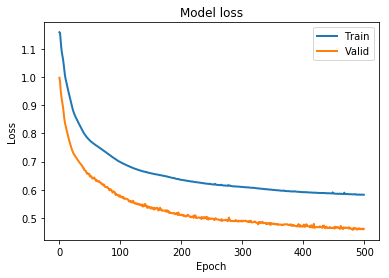

In [25]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')

plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')

plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Classification
### The autoencoder Reconstruction Error is utilized for Rare Event classification
* High reconstruction errors will be denoted as sheet breaks
* This determination requires a Threshold

### Establish the classification Threshold using the Validation set
* arrays must be flattened to compute MSE

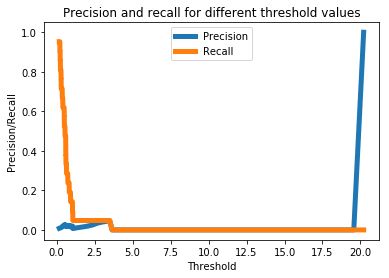

In [26]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)

mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class,
                                                               error_df.Reconstruction_error)

plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth = 5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth = 5)

plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

### Perform Classification on the Test set
* use a Threshold of 0.8

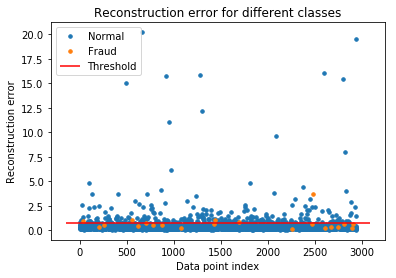

In [27]:
threshold_fixed = 0.7
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker = 'o', ms = 3.5, linestyle = '',
            label = "Fraud" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
          colors = "r", zorder = 100, label = 'Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

* Orange dots (above the red line) represent True Positives
* Blue dots represent False Positives

### View these metrics in a Confusion Matrix

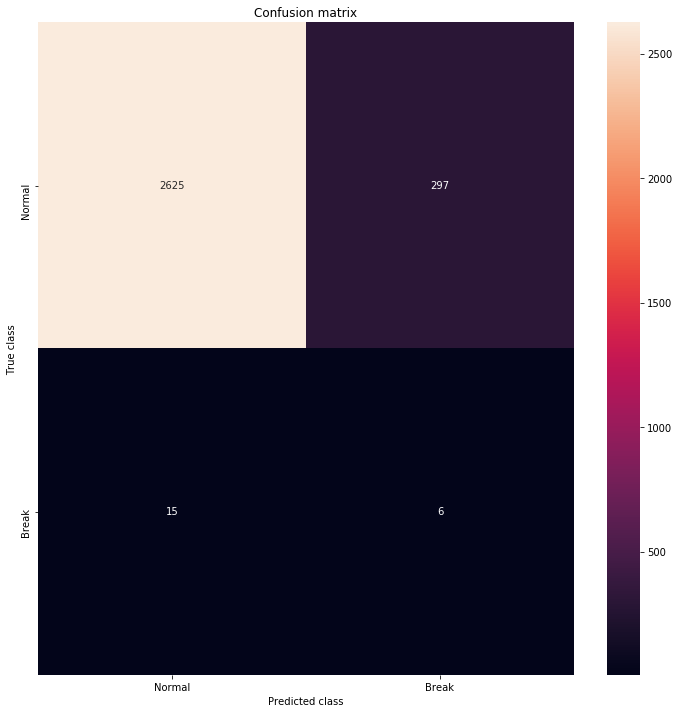

In [28]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = "d");

plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

* Predicted 6 out of 21 (28.57 %) break instances - at 2 or 4 minutes ahead of time

### View ROC curve and AUC
* these metrics evaluate classification models
* Receiver Operator Characteristic (ROC) curve - plots True Positive Rate (y-axis) against False Positive Rate (x-axis)
* Area Under Curve (AUC) - provides rate of successful classification

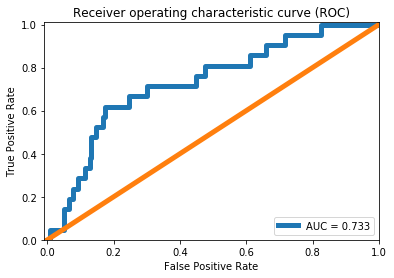

In [29]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)

roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### The AUC is 0.733 - This can be used to compare this model to the alternative approach, using the simple Autoencoder with Dense layers